In [19]:
import matplotlib
import matplotlib.pyplot as plt
import gzip, pickle
import seaborn as sn
import pandas as pd
import riem_funcs
from riem_funcs import *
import scipy.linalg as linalg
import sklearn.cluster

### Consider the simplest non-trivial case of a variance-covariance matrix: a length 2 random vector 
$X = \begin{bmatrix}x_1 \\ x_2 \end{bmatrix}$.
Say each $x_i$ has mean zero, so that the variance covariance matrix is $\mathbb E[XX^T]$.

If we denote this matrix by $\begin{bmatrix} a & b \\ b & d \end{bmatrix}$, then the fact that the matrix is
positive definite is equivalent to the conditions $ad-b^2 > 0$ and $a > 0$. Note that this implies $d > 0$.

Make the change of coordinates $a = u + v$, $d = u - v$ (a rotation by 45 degrees plus a scaling) to turn this into 
the conditions $u^2 - v^2 - b^2 > 0$ where $u > |v|$.

This is the equation of a (filled in) cone which opens along the $u$-axis.

In [4]:
from mpl_toolkits.mplot3d import Axes3D

In [30]:
xdom,ydom = np.meshgrid(np.linspace(0,400,400),np.linspace(0,2*np.pi,50,endpoint=True))

In [31]:
u = xdom
v = xdom*np.cos(ydom)
b = xdom*np.sin(ydom)

<IPython.core.display.Javascript object>


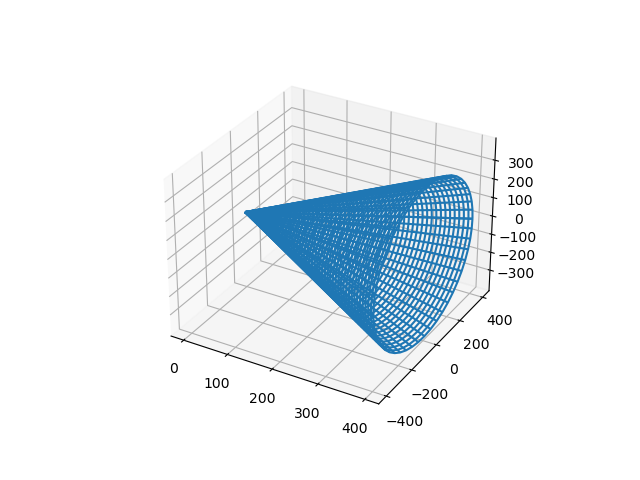

In [32]:
%matplotlib notebook
fig,ax = plt.subplots(subplot_kw={'projection':'3d'})
ax.plot_wireframe(u,v,b)

To see what this looks like in the original $a,b,d$ coordinates we just plug in the formula

<IPython.core.display.Javascript object>


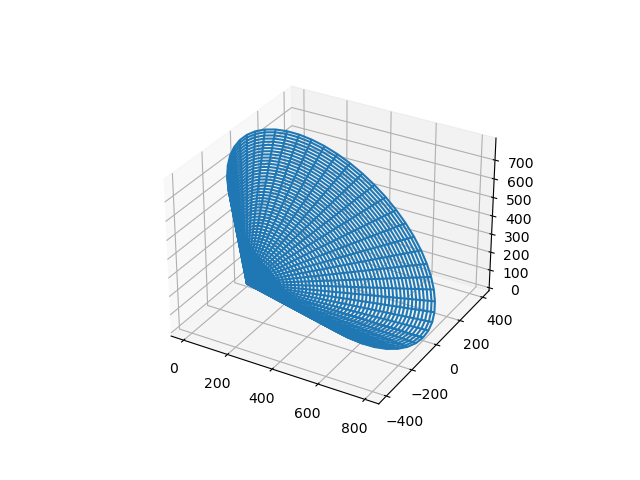

In [34]:
conea = u + v
coned = u - v
coneb = b
fig,ax = plt.subplots(subplot_kw={'projection':'3d'})
ax.plot_wireframe(conea,coneb,coned)

### Now let's look at some examples of where  covariance matrices corresponding to fMRI data sit on this cone

In [20]:
data_dir = 'data'+os.sep
meta_dir = 'metadata'+os.sep
valid_runs_uiuc = pd.read_csv(meta_dir + 'UIUC_valid_runs.csv',index_col='ID',header=0,names=['ID','A','B','C','D','E','F','G'],usecols=['ID','A','B'])
valid_runs_whasc = pd.read_csv(meta_dir + 'WHASC_valid_runs.csv',index_col='ID',header=0,names=['ID','A','B','C','D'],usecols=['ID','A','B'])

valid_runs_dict_uiuc = {re.sub(r'\d+_','',idx.rstrip('*')): row.values for idx,row in valid_runs_uiuc.iterrows()}
valid_runs_dict_whasc = {re.sub(r'\d+_','',idx.rstrip('*')): row.values for idx,row in valid_runs_whasc.iterrows()}

metadata_uiuc = pd.read_csv(meta_dir + 'UIUC_metadata.csv',index_col = 'ID')
metadata_whasc = pd.read_csv(meta_dir + 'WHASC_metadata.csv',index_col = 'ID')

uiuc_files = [data_dir+'UIUC'+os.sep+fname for fname in os.listdir(data_dir+'UIUC') if not fname.startswith('.')]
whasc_files = [data_dir+'WHASC'+os.sep+fname for fname in os.listdir(data_dir+'WHASC') if not fname.startswith('.')]

uiuc_samples = []
count =0
for fname_prefix in uiuc_files:
    runs = [run for run in os.listdir(fname_prefix) if run.startswith('run') and not(fname_prefix.endswith('B') and 
                                                                                     (run.endswith('1') or run.endswith('2')))]
    for run in runs:
        count += 1
        ID = re.findall(r'\d+_(\d+)_',fname_prefix)[0]
        Group_binary = re.findall(r'(\d+)_\d+_',fname_prefix)[0][1:]
        if Group_binary == "00":
            Group = 'ctr'
        if Group_binary == "01":
            Group = 'hl'
        if Group_binary == "10":
            Group = 'tin'
        if Group_binary == "11":
            Group = 'tin_hl'
        
        filename = "ROI_matrix_data_33.csv"
        try:
            timeSeries = np.genfromtxt(fname_prefix+os.sep+run+os.sep+filename,delimiter=',')
        except OSError:
            continue
            
        if timeSeries.shape == (33,300):
            uiuc_samples.append({'TimeSeries':timeSeries,'Location':'chm','Run':run,'ID':ID,'Group':Group,
                                 'TFI':metadata_uiuc.loc[int(ID),'TFI_A']})     
            
whasc_samples = []
for fname_prefix in whasc_files:
    runs = [run for run in os.listdir(fname_prefix) if run.startswith('run') and not(fname_prefix.endswith('B') and 
                                                                                     (run.endswith('1') or run.endswith('2')))]
    for run in runs:
        ID = re.findall(r'\d+_(\d+)_',fname_prefix)[0]
        Group_binary = re.findall(r'(\d+)_\d+_',fname_prefix)[0][1:]
        if Group_binary == "00":
            Group = 'ctr'
        if Group_binary == "01":
            Group = 'hl'
        if Group_binary == "10":
            Group = 'tin'
        if Group_binary == "11":
            Group = 'tin_hl'
        filename = "ROI_matrix_data_33.csv"
        timeSeries = np.genfromtxt(fname_prefix+os.sep+run+os.sep+filename,delimiter=',')
        
        whasc_samples.append({'TimeSeries':timeSeries,'Location':'san','Run':run,'ID':ID,'Group':Group,
                             'TFI':metadata_whasc.loc[int(ID),'TFI_A']})

C:\Users\danie\anaconda3\envs\Neuro\lib\site-packages\ipykernel_launcher.py:35: UserWarning: genfromtxt: Empty input file: "data\UIUC\Fh_001_285_B\run5\ROI_matrix_data_33.csv"


In [21]:
data = {'samples':uiuc_samples+whasc_samples}

In [22]:
X = np.array([sample['TimeSeries'][:2] for sample in data['samples']]) #if data_selector(sample,valid_runs_dict_uiuc,valid_runs_dict_whasc)])  
y = np.array([get_label_8(sample['Group'],sample['Location']) for sample in data['samples']])# if data_selector(sample,valid_runs_dict_uiuc,valid_runs_dict_whasc)])
covest = Covariances()
covs = covest.fit_transform(X)

In [23]:
covs.shape

(475, 2, 2)

In [45]:
upper_tri_cov = [cov[np.triu_indices(2)] for cov in covs]

<IPython.core.display.Javascript object>


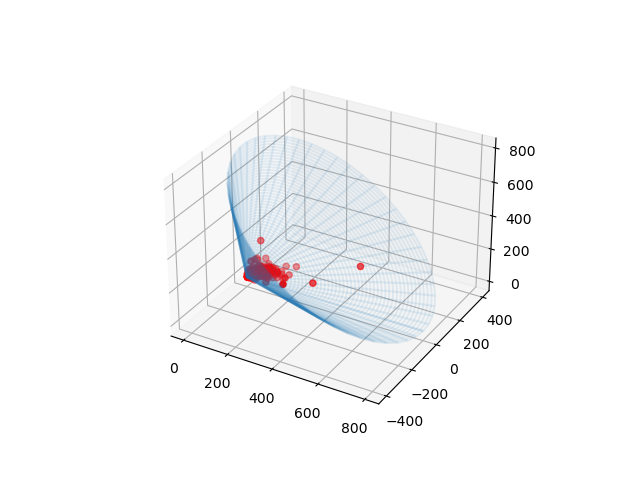

In [46]:
a = []
b = []
d = []
for cov in upper_tri_cov:
    x,y,z = cov
    a.append(x)
    b.append(y)
    d.append(z)
fig,ax = plt.subplots(subplot_kw={'projection':'3d'})
ax.plot_wireframe(conea,coneb,coned,alpha=0.1)
ax.scatter(a,b,d,c='red')


### If we use correlation matrices instead there's only one nontrivial value (b), so we don't get super interesting results (we'd have to use our higher dimensional data, and plotting would become a problem)

<IPython.core.display.Javascript object>


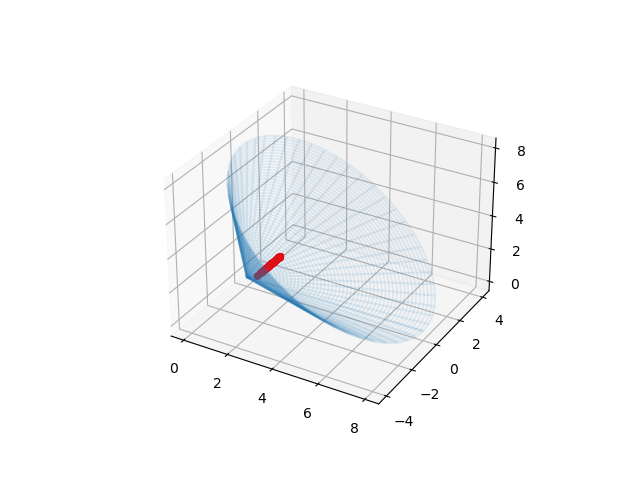

In [43]:
correlations = Correlations()
corrs = correlations.fit_transform(X)
upper_tri_corr = [cov[np.triu_indices(2)] for cov in corrs]
a = []
b = []
d = []
for cov in upper_tri_corr:
    x,y,z = cov
    a.append(x)
    b.append(y)
    d.append(z)
    
fig,ax = plt.subplots(subplot_kw={'projection':'3d'})
ax.plot_wireframe(conea/100,coneb/100,coned/100,alpha=0.1)
ax.scatter(a,b,d,c='red')

### Now, let's compare two types of normalization on covariance matrices, Z-scoring and the Riemannian framework
When we $Z$-score the data will no longer sit inside the cone (because it's mean centered), but plotting the cone still helps visualize the transformation

<IPython.core.display.Javascript object>


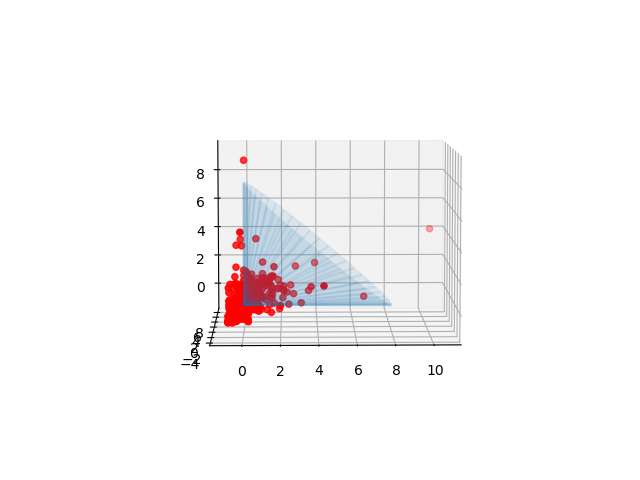

In [49]:
a = []
b = []
d = []
for cov in upper_tri_cov:
    x,y,z = cov
    a.append(x)
    b.append(y)
    d.append(z)
    
a = np.array(a)
b = np.array(b)
d = np.array(d)
az = (a - np.mean(a))/np.std(a)
bz = (b - np.mean(b))/np.std(b)
dz = (d - np.mean(d))/np.std(d)
fig,ax = plt.subplots(subplot_kw={'projection':'3d'})
ax.plot_wireframe(conea/100,coneb/100,coned/100,alpha=0.1)
ax.scatter(az,bz,dz,c='red')

### Now for the Riemannian approach
- The process used here already centers the data around (0,0,0) by definition of the Frechet mean under the affine invariant metric
- The data no longer fits in the cone, because we've taken a logarithm to move from the positive definite cone to its tangent space (the linear space of symmetric matrices)

<IPython.core.display.Javascript object>


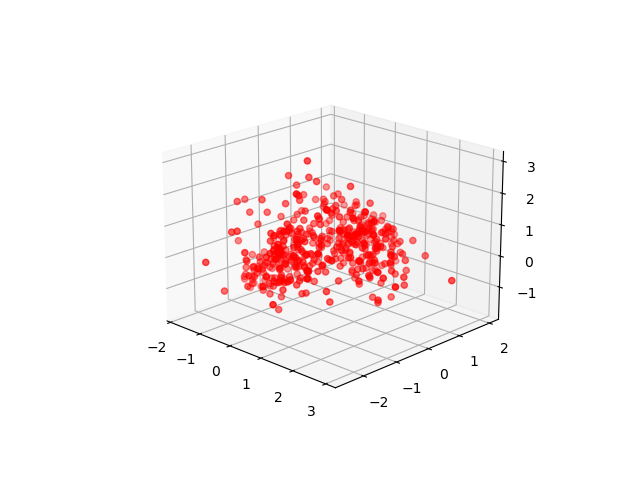

In [50]:
#covest defined above
#ts already grabs the upper triangle
ts = TangentSpace()
transformer = make_pipeline(covest,ts)
transformed = transformer.fit_transform(X)
a = []
b = []
d = []
for cov in transformed:
    x,y,z = cov
    a.append(x)
    b.append(y)
    d.append(z)
    
fig,ax = plt.subplots(subplot_kw={'projection':'3d'})
#ax.plot_wireframe(conea/100,coneb/100,coned/100,alpha=0.1)
ax.scatter(a,b,d,c='red')

### With the Riemannian approach, the data is more uniformly spread out